In [47]:
import json
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from copy import deepcopy
import os
from IPython.core.getipython import get_ipython

def load_from_json(file_path):
    """
    Load a dictionary from a JSON file and convert serialized data back to DataFrames.

    Parameters:
    - file_path: Path to the JSON file.

    Returns:
    - Dictionary with lists of DataFrames.
    """
    
    # Load the dictionary from the JSON file
    with open(file_path, 'r') as file:
        loaded_dict = json.load(file)

    # Convert serialized data back to DataFrames
    dataframes_dict = {}
    for doc_key, doc_value in loaded_dict.items():
        pages_list_df = [pd.DataFrame(page_data) for page_data in doc_value['pages']]
        dataframes_dict[doc_key] = {
            'project_id': doc_value['project_id'],
            'document_name': doc_value['document_name'],
            'document_status': doc_value['document_status'],
            'document_text': doc_value['document_text'],
            'pages': pages_list_df,
        }

    return dataframes_dict

In [48]:
def draw_boxes(image_path: str, image_short_path: str, dataframe: pd.DataFrame, bbox_column: str) -> Image.Image:
    """
    Draw bounding boxes and their labels on the image.

    Parameters:
    - image_path: Path to the image on which bounding boxes will be drawn.
    - dataframe: DataFrame containing bounding boxes and labels.
    - bbox_column: Column name in the dataframe which contains bounding boxes.
    
    Returns:
    - Modified image with bounding boxes and labels.
    """
    
    # Open the image
    image = Image.open(image_path)
    image = image.convert('RGB')
    
    width, height = image.size

    # Initialize drawing context and font
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    print("image_path: ", image_path)
    print("image_short_path: ", image_short_path)
    
    dataframe = dataframe[dataframe['file_path'] == image_short_path]
    print(dataframe.head())

    for _, row in dataframe.iterrows():
        # Extract bounding box and label from the dataframe
        #print(row[bbox_column])
        #print(type(row[bbox_column]))
        #box = eval(row[bbox_column])  # Convert string representation of list to actual list
        box = row[bbox_column]
        label = row['label']
        
        # Draw the bounding box on the image
        draw.rectangle(box, outline="red", width=2)
        
        # Calculate label position (slightly above the bounding box)
        if label != 'NO_LABEL':
            label_position = (box[0], box[1] - 15)  # 15 pixels above the bounding box
            draw.text(label_position, label, font=font, fill="blue")
    
    return image

In [52]:
def draw_boxes_from_user_input():
    """
    Draw bounding boxes based on the configuration provided by the user.
    """
    
    project_id = input("Please enter the project ID: ")
    document_id = input("Please enter the document ID: ")
    page_number = input("Please enter the page number: ")

    # Prompt the user for the type of bounding box2
    bbox_type = input("Choose the type of bounding box to draw ( bbox / merged_bbboxes / merged_bbboxes_by_line ): ")
    while bbox_type not in ['bbox', 'merged_bbboxes', 'merged_bbboxes_by_line']:
        print("Invalid choice. Please select a valid bounding box type.")
        bbox_type = input("Choose the type of bounding box to draw ( bbox / merged_bbboxes / merged_bbboxes_by_line ): ")
    
    # Get the directory where the script is located
    #script_dir = os.path.dirname(os.path.realpath(__file__))
    script_dir = os.path.join(os.getcwd(), get_ipython().starting_dir)
    # Move one directory up from the script's directory
    parent_dir = os.path.dirname(script_dir)

    konfuzio_document_dir = f"data_{project_id}/documents/{document_id}/"
   
 
    # Path to stored data
    data_dir = "data"
    file_name = f"project_{project_id}_docs.json"
    # Construct the file path relative to the script's directory
    dir_path = os.path.join(parent_dir, data_dir) 
    file_path = os.path.join(dir_path, file_name) 

    # Load the corresponding dataframe
    print(f"Trying to load {file_path} ...")
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} does not exist. Please ensure you've entered the correct details.")
        return
    json_data = load_from_json(file_path)

    doc_key = f"{document_id}"
    if doc_key not in json_data:
        print(f"Error: Document ID {document_id} not found in stored datasets.")
        return
    
    while len(json_data[doc_key]['pages']) < int(page_number):
        page_number = input("Specified page number out of range. Please enter a page number smaller or equal {}:".format(len(json_data[doc_key]['pages'])))
        
    image_name = f"page_{page_number}.png"
    # Construct the file path relative to the script's directory
    image_path = os.path.join(parent_dir, konfuzio_document_dir, image_name) 
    if not os.path.exists(image_path):
        print(f"Error: Image {file_path} does not exist. Please ensure it was saved before.")
        return
    
    image_short_path = os.path.join(konfuzio_document_dir, image_name) 
    dataframe_page = json_data[doc_key]['pages'][int(page_number) - 1]
    df = pd.DataFrame(dataframe_page)
    print(df.head())

    # Draw boxes on the image
    image = draw_boxes(image_path, image_short_path, df, bbox_type)  # or 'merged_bbboxes' or 'merged_bbboxes_by_line' based on your requirement
    #image.show()
    #image_save_path = os.path.join(parent_dir, data_dir, "output.png")
    #image.show(image_save_path)

    return image

In [35]:
dataset_path = "/path/to/data/project_2_docs.json"
converted_data_df = load_from_json(dataset_path)

In [36]:
converted_data_df.keys()

dict_keys(['339', '340', '341'])

In [37]:
converted_data_df['339'].keys()

dict_keys(['project_id', 'document_name', 'document_status', 'document_text', 'pages'])

In [38]:
converted_data_df['339']['document_name']

'axa_MIH408883794.pdf'

In [39]:
converted_data_df['339']['pages'][1]


,annotation_id,page_index,line_number,offset_string,offset_string_original,top,bottom,x0,y0,x1,y1,start_offset,end_offset,file_name,file_path,label,label_set,bbox,merged_bbboxes,merged_bbboxes_by_line
0,None,2,72,Freundlich,Freundlich,134.1688,140.6488,128.736145,232.034414,230.291341,243.241065,2927,2937,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[128, 232, 230, 243]","[128, 232, 230, 243]","[128, 232, 230, 243]"
1,None,2,72,grüßt,grüßt,134.3632,142.3696,242.537703,232.370613,292.108088,246.217054,2938,2943,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[242, 232, 292, 246]","[242, 232, 292, 246]","[242, 232, 292, 246]"
2,None,2,72,Sie,Sie,134.1688,140.6488,305.262971,232.034414,333.489341,243.241065,2944,2947,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[305, 232, 333, 243]","[305, 232, 333, 243]","[305, 232, 333, 243]"
3,None,2,78,[Schumacher,[Schumacher,204.7504,212.5048,160.696163,354.099753,216.949776,367.510380,2975,2986,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[160, 354, 216, 367]","[160, 354, 216, 367]","[160, 354, 216, 367]"
4,None,2,78,],],203.9800,211.7272,219.625556,352.767407,226.321230,366.165582,2987,2988,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[219, 352, 226, 366]","[219, 352, 226, 366]","[219, 352, 226, 366]"
5,None,2,78,(Harboræ-Muller,(Harboræ-Muller,204.7504,213.2752,408.448525,354.099753,490.140720,368.842726,3012,3027,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[408, 354, 490, 368]","[408, 354, 490, 368]","[408, 354, 490, 368]"
6,None,2,78,],],204.7504,213.2752,492.816500,354.099753,500.843841,368.842726,3028,3029,page_2.png,data_2/documents/339/page_2.png,NO_LABEL,NO_LABEL_SET,"[492, 354, 500, 368]","[492, 354, 500, 368]","[492, 354, 500, 368]"


Trying to load /Users/christopherczaban/Local_Project_Files/konfuzio_sdk_DS_KonfuzioVM_Sematic-Segmentation-Tests/document_tools/konfuzio-huggingface-annotations-converter/data/project_2_docs.json ...
  annotation_id  page_index  line_number offset_string offset_string_original  \
0          None           2           72    Freundlich             Freundlich   
1          None           2           72         grüßt                  grüßt   
2          None           2           72           Sie                    Sie   
3          None           2           78   [Schumacher            [Schumacher   
4          None           2           78             ]                      ]   

        top    bottom          x0          y0          x1          y1  \
0  134.1688  140.6488  128.736145  232.034414  230.291341  243.241065   
1  134.3632  142.3696  242.537703  232.370613  292.108088  246.217054   
2  134.1688  140.6488  305.262971  232.034414  333.489341  243.241065   
3  204.7504  212.504

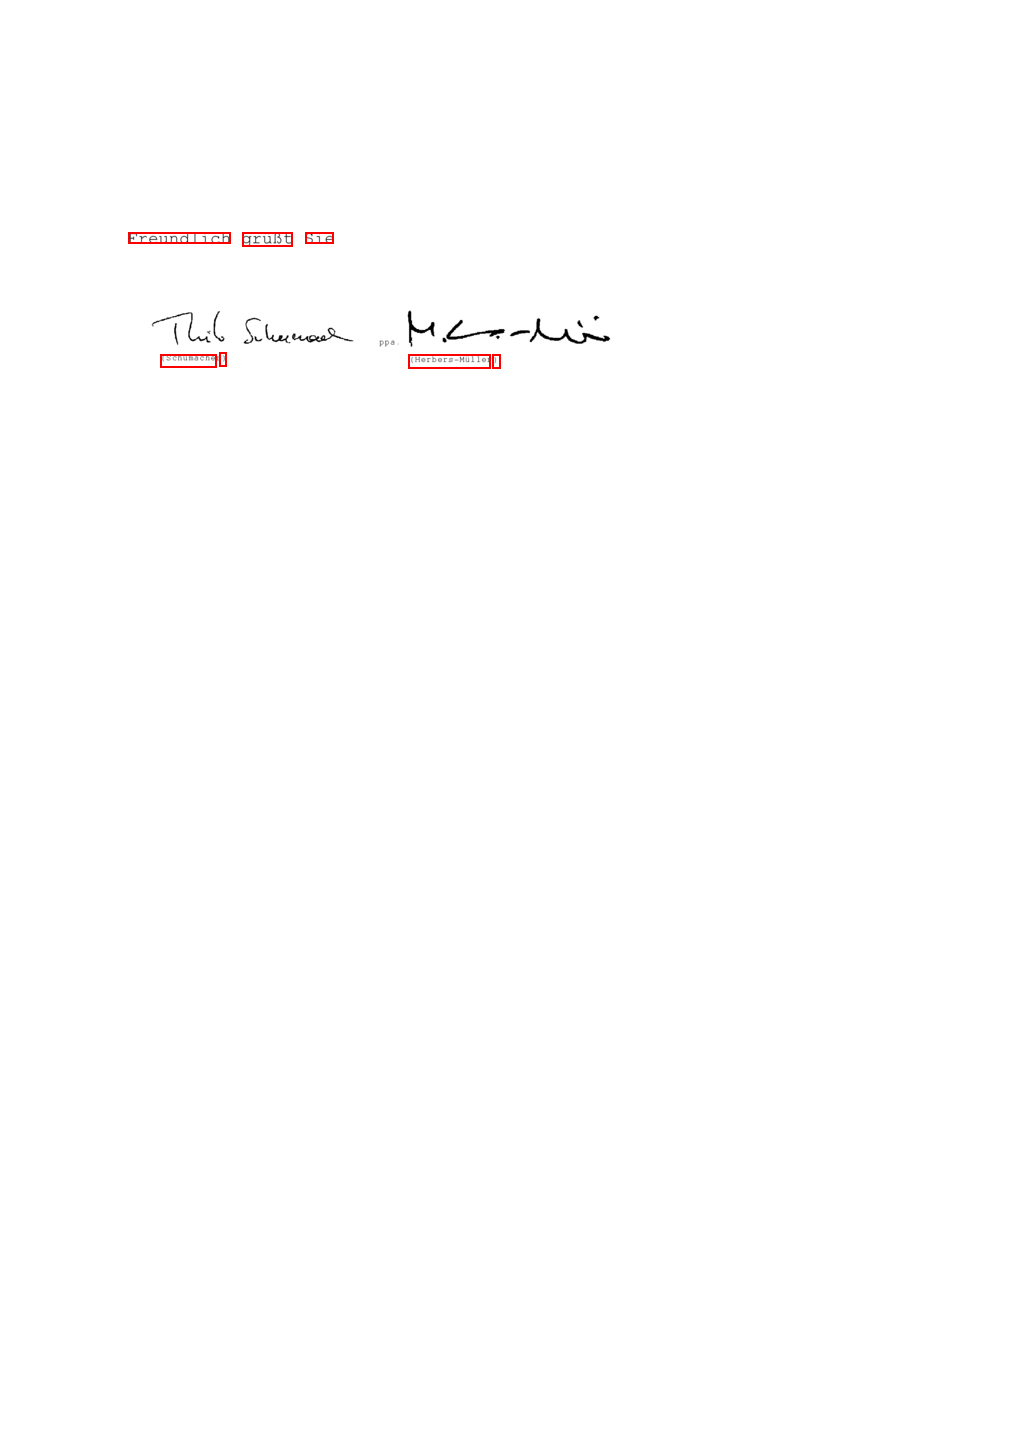

In [53]:
draw_boxes_from_user_input()